# DYNAMOL

Version 20201201 - Kyle Reeves (@kgreeves), Mathieu Salanne (@salanne)

This jupyter notebook allows to simulate a monoatomic system in the [microcanonical ensemble](https://en.wikipedia.org/wiki/Microcanonical_ensemble) (*NVE*) using [molecular dynamics](https://en.wikipedia.org/wiki/Molecular_dynamics).

The interactions are calculated using the [Lennard-Jones potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential) :

$$
V(r) = 4\epsilon \left[ \left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^6 \right]
$$

It accounts for short-range repulsion and dispersion interactions only, so in practice we can only simulate noble gases.

First we need to import the `numpy`, `matplotlib`, `MDAnalysis` and `nglview` libraries:

In [41]:
import matplotlib.pyplot as plt
import numpy as np

#For Visualization
import MDAnalysis
import nglview as nv
from nglview.datafiles import PDB, XTC

Then we define a series of parameters that will often be changed :
- `Nsteps` is the number of steps of the simulation
- `Nequil` is the number of steps for equilibration (the remaining steps are production)
- `Nrescale` is the frequency at which the velocities are rescaled during equilibration
- `Frequency_write_physical_properties` is the frequency at which the physical quantities are saved
- `Frequency_write_trajectories` is the frequency at which the trajectories are saved
- `Ngrid_rdf` defines the number of points for the computation of the [radial distribution function](https://en.wikipedia.org/wiki/Radial_distribution_function)
- `Box_size` is the length of the cubic box edge
- `Temperature_imposed` is the imposed temperature during equilibration

In [42]:
Nsteps = 1000
Nequil = 100
Nrescale = 1
Frequency_write_physical_properties = 1
Frequency_write_trajectories = 10
Ngrid_rdf = 100
Box_size = 15.768 # 15.768 for solid Ar at 0 K
Temperature_imposed = 120.0

And a series of parameters that we should not change much :
- `Timestep_fs` is the timestep (in fs, 1 fs = 10$^{-15}$ s)
- `Natoms` is the number of atoms (Warning! Changing this requires a few additional changes below)
- `Mass` is the atomic mass (in g mol$^{-1}$) of the simulated compound
- `Epsilon` is the $\epsilon$ parameter of the Lennard-Jones potential (in kJ mol$^{-1}$)
- `Sigma` is the $\sigma$ parameter of the Lennard-Jones potential (in $\unicode{x212B}$)

The initial settings correspond to the [Argon](https://www.webelements.com/argon/) atom.

In [43]:
Timestep_fs = 5.0
Natoms = 108
Mass = 39.948
Epsilon = 0.9966288
Sigma = 3.405

We also need to define a few physical constants :

In [44]:
Avogadro = 6.022140857e23
Boltzmann = 1.38064852e-23
Bohr = 0.52917721067e-10
Pi = 3.14159265358979323

For consistency, all the computations are made in [atomic units](https://en.wikipedia.org/wiki/Hartree_atomic_units), then the results are plotted in conventional units. We therefore need define a series of conversion factors.

In [45]:
Time_fs2au = 1.0 / 2.4188843265857e-2
Length_Angstrom2au = 1.0e-10 / Bohr
Length_au2Angstrom = 1.0 / Length_Angstrom2au
Energy_au2J = 4.359744650e-18
Energy_J2au = 1.0 / Energy_au2J
Energy_kJpermol2au = 1.0e3 * Energy_J2au / Avogadro
Energy_au2kJpermol = 1.0 / Energy_kJpermol2au
Mass_gpermol2au = 1.0e-3 / (Avogadro * 9.10938356e-31)
Pressure_au2bar = 2.9421015697e8

Then we do all the corresponding conversions :

In [46]:
Box_size = Box_size * Length_Angstrom2au
Epsilon = Epsilon * Energy_kJpermol2au
Sigma = Sigma * Length_Angstrom2au
Mass = Mass * Mass_gpermol2au 
Timestep = Timestep_fs * Time_fs2au
Boltzmann_au = Boltzmann * Energy_J2au

Finally before getting started we compute a few quantities (number of data points that will be accumulated, cut-off length, for the LJ interactions and interval for the calculation of the [radial distribution function](https://en.wikipedia.org/wiki/Radial_distribution_function)).

In [47]:
Nwrite_physical_properties = int(Nsteps / Frequency_write_physical_properties)
Nwrite_physical_properties_equil = int(Nequil / Frequency_write_physical_properties)
Rcutoff = min( Box_size/2.0 , 2.5*Sigma )
Rcutoff2 = Rcutoff**2
Dr_rdf = Rcutoff/float(Ngrid_rdf)

Note that all the variables defined so far will not change until the end, they are therefore noted with capital letters. In the following we define several functions that will be used by the program.

**Function 1**: It computes the temperature and kinetic energy using the instantaneous velocities

In [48]:
def Compute_Temperature(velocities):
    kinetic_energy = 0.0
    for i in range(Natoms) :
        kinetic_energy = kinetic_energy + 0.5*Mass*np.dot(velocities[i,:],velocities[i,:])
        
    temperature = 2.0 * kinetic_energy / (3.0 * Boltzmann_au * Natoms)

    configurational_pressure = 2.0 * kinetic_energy / (3.0 * Box_size**3)
    
    return kinetic_energy,temperature, configurational_pressure

**Function 2**: It computes the long-range correction on the energy and pressure due to the use of a cut-off in the Lennard-Jones potential

In [49]:
def Compute_long_range_corrections():

    long_range_correction_energy = 4.0 * Epsilon * Sigma**3 * Natoms**2 * ((Sigma/Rcutoff)**9/3.0 -(Sigma/Rcutoff)**3)
    long_range_correction_energy = long_range_correction_energy * 2.0 * Pi / (3.0 * Box_size**3)

    long_range_correction_pressure = 4.0 * Epsilon * Sigma**3 * Natoms**2 * ((Sigma/Rcutoff)**9*4.0 - (Sigma/Rcutoff)**3*6.0)
    long_range_correction_pressure = long_range_correction_pressure * 2.0 * Pi / (3.0 * Box_size**3)

    long_range_correction_pressure = long_range_correction_pressure / (3.0 * Box_size**3)

    return long_range_correction_energy, long_range_correction_pressure

**Function 3**: It computes the forces, the virial and the potential energy of the system using the instantaneous positions. This is where most of the computational cost of the program lies due to the double-loop over the atoms. The  distance histograms necessary to calculate the [radial distribution function](https://en.wikipedia.org/wiki/Radial_distribution_function) are also accumulated here.

In [50]:
def Compute_Forces(positions,rdf):

    forces = np.zeros([Natoms,3])
    rij = np.zeros([3])
    potential_energy = 0.0 
    virial = 0.0

    for i in range(Natoms-1) :
        for j in range(i+1,Natoms) :
            rij[:] = positions[i,:]-positions[j,:]
            for k in range(3):
                if(rij[k] > Box_size/2.0):
                    rij[k] = rij[k]-Box_size
                if(rij[k] < -Box_size/2.0):
                    rij[k] = rij[k]+Box_size             
            rijsquare = np.dot(rij,rij)
            if(rijsquare < Rcutoff2):
                rijdist = np.sqrt(rijsquare)
                rdf[int(rijdist/Dr_rdf)] += 1.0
                attractive_term = (Sigma/rijdist)**6
                repulsive_term = attractive_term**2
                fij = 4.0 * Epsilon * (12.0*repulsive_term-6.0*attractive_term)/rijsquare
                potential_energy = potential_energy +  4.0 * Epsilon * (repulsive_term - attractive_term)
                forces[i,:] = forces[i,:] + fij*rij[:]
                forces[j,:] = forces[j,:] - fij*rij[:]
                virial = virial + 4.0 * Epsilon * (12.0*repulsive_term-6.0*attractive_term)

    virial = virial/(3.0*Box_size**3)            

    return potential_energy, forces, virial, rdf

**Function 4**: It performs the first half of the [velocity-Verlet algorithm](https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet), in which the new positions and the temporary new velocities are computed

In [51]:
def Verlet_halfstep1(positions, velocities, forces):
    
    newpositions = positions + velocities * Timestep + 0.5*Timestep**2*forces/Mass
    newvelocities = velocities + 0.5*Timestep*forces/Mass

    return newpositions, newvelocities

**Function 5**: It performs the second half of the [velocity-Verlet algorithm](https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet), in which the new velocities are computed

In [52]:
def Verlet_halfstep2(velocities, forces):

    newvelocities = velocities + 0.5*Timestep*forces/Mass

    return newvelocities

**Function 6**: The positions are initialized by placing the atoms on a [face-centered cubic lattice](https://en.wikipedia.org/wiki/Close-packing_of_equal_spheres#FCC_and_HCP_Lattices) replicated three times along each direction

In [53]:
def initialize_positions():

    origin = np.zeros([3])
    initial_positions = np.zeros([Natoms,3])
    shift = Box_size / 3.0

    origin[0] = 0.0
    origin[1] = 0.0
    origin[2] = 0.0

    l = 0
    for i in range (3) :
        for j in range (3) :
            for k in range (3) :
                initial_positions[l,0] = origin[0] + i*shift
                initial_positions[l,1] = origin[1] + j*shift
                initial_positions[l,2] = origin[2] + k*shift  
                l = l+1

    origin[0] = 0.5
    origin[1] = 0.5
    origin[2] = 0.0
    origin = origin * shift

    for i in range (3) :
        for j in range (3) :
            for k in range (3) :
                initial_positions[l,0] = origin[0] + i*shift
                initial_positions[l,1] = origin[1] + j*shift
                initial_positions[l,2] = origin[2] + k*shift  
                l = l+1

    origin[0] = 0.5
    origin[1] = 0.0
    origin[2] = 0.5
    origin = origin * shift

    for i in range (3) :
        for j in range (3) :
            for k in range (3) :
                initial_positions[l,0] = origin[0] + i*shift
                initial_positions[l,1] = origin[1] + j*shift
                initial_positions[l,2] = origin[2] + k*shift  
                l = l+1

    origin[0] = 0.0
    origin[1] = 0.5
    origin[2] = 0.5
    origin = origin * shift

    for i in range (3) :
        for j in range (3) :
            for k in range (3) :
                initial_positions[l,0] = origin[0] + i*shift
                initial_positions[l,1] = origin[1] + j*shift
                initial_positions[l,2] = origin[2] + k*shift  
                l = l+1

    return initial_positions

**Function 7**: It applies [periodic boundary conditions](https://en.wikipedia.org/wiki/Periodic_boundary_conditions) by putting back the atoms inside the main cell

In [54]:
def inside_box(positions):

    for i in range(Natoms) :
        for j in range(3) :
            if(positions[i,j] > Box_size) :
                positions[i,j] = positions[i,j] - Box_size
            if(positions[i,j] < 0.0) :
                positions[i,j] = positions[i,j] + Box_size

    return positions

**Function 8**: It removes the center of mass velocity to avoid the [flying ice cube effect](https://en.wikipedia.org/wiki/Flying_ice_cube)

In [55]:
def remove_com_velocity(velocities):

    velocity_com = np.zeros([3])
    for i in range(Natoms) :
        velocity_com[:] = velocity_com[:] + velocities[i,:]

    velocity_com = velocity_com / Natoms

    for i in range(Natoms) :
        velocities[i,:] = velocities[i,:] - velocity_com[:]

    return velocities

**Function 9**: It performs velocity rescaling in order to equal the instantaneous temperature to the target one

In [56]:
def rescale_velocities(velocities):

    temperature = Compute_Temperature(velocities)[1]
    scaled_velocities = velocities * np.sqrt(Temperature_imposed / temperature)            

    return scaled_velocities

**Function 10**: Velocities are initialized according to a random distribution, then the center of mass velocity is removed (by calling **Function 8**) and the velocities are rescaled (by calling **Function 9**)

In [57]:
def initialize_velocities():

    initial_velocities = np.random.normal(0,0.001,[Natoms,3])
    initial_velocities = remove_com_velocity(initial_velocities)
    initial_velocities = rescale_velocities(initial_velocities)

    return initial_velocities

**Function 11**: It creates arrays for all the physical properties (temperature, pressure, kinetic, potential and total energies, radial distribution functions) that will be computed during the simulation

In [58]:
def initialize_physical_properties():

    temperature = np.zeros([Nwrite_physical_properties])
    pressure = np.zeros([Nwrite_physical_properties])
    kinetic_energy = np.zeros([Nwrite_physical_properties])
    potential_energy = np.zeros([Nwrite_physical_properties])
    total_energy = np.zeros([Nwrite_physical_properties])
    rdf = np.zeros([Ngrid_rdf])
    time = np.zeros([Nwrite_physical_properties])

    return temperature, pressure, kinetic_energy, potential_energy, total_energy, rdf, time

__Function 12:__ Used to prepare the trajectory data to be visualized.

In [59]:
def Generate_MD_Traj(Natoms,AtomNames,Box_size,Coordinates):
    
    #In the case of a gas, residues are notapplicable here.
    Nresidues = Natoms
    
    #Generate the "Universe" which defines the systems (Natoms and AtomNames)
    U1 = MDAnalysis.Universe.empty(Natoms,
                                   Nresidues,
                                   atom_resindex=np.arange(Nresidues),
                                   residue_segindex=[0]*Nresidues,
                                   trajectory=True,
                                  )
    
    #U1.triclinic_dimensions = [[Box_size,0,0],[0,Box_size,0],[0,0,Box_size]]

    #Additional Information that should be defined to complete "Universe." Many of these values are
    #just dummy values. "Type" is the most relevant parameter defining the element type.
    U1.add_TopologyAttr('name',[str(AtomNames)]*Nresidues)
    U1.add_TopologyAttr('type',[str(AtomNames)]*Nresidues) # Element Type
    U1.add_TopologyAttr('resnames',[str(AtomNames)]*Nresidues)
    U1.add_TopologyAttr('resid',list(range(1,Nresidues+1)))
    U1.add_TopologyAttr('segid',['DUMMY'])
    
    

    #Assign positions from an np.array of trajectory coordinates
    U1.load_new(np.array(Coordinates), order='fac')
    U1.dimensions = np.array([Box_size,Box_size,Box_size,90,90,90])

    return U1

def Visualize_Trajectory(MD_Universe):
    
    #Generates the object that is ultimately returned and visualized
    U1_view = nv.show_mdanalysis(MD_Universe)
    U1_view.add_representation('spacefill', selection='all',color='#660066',opacity=0.75)

    #Paramters used to make the system easier to see. Background color, perspective, shadows, etc.
    U1_view.add_unitcell()
    U1_view.camera = 'orthographic'
    U1_view.center()
    U1_view.parameters = {
    # "percentages, "dist" is distance too camera in Angstrom
    "clipNear": 20, "clipFar": 90, "clipDist": 10,
    # percentages, start of fog and where on full effect
    "fogNear": 20, "fogFar": 90,
    # background color
    "backgroundColor": "#F5F5F5",
}
    return U1_view

The main program may be splitted in three parts:
- An initialization in which starting values are assigned to the positions and velocities, and the various arrays are created
- An equilibration phase during which the velocities are rescaled at each step
- A production phase during which the system should sample equilibrium configurations only. It is during this phase that we will accumulate the physical properties

In [60]:
## Initialization
coords_MD= [] 
positions = initialize_positions()
velocities = initialize_velocities()
temperature, pressure, kinetic_energy, potential_energy, total_energy, rdf, time = initialize_physical_properties()
long_range_correction_energy, long_range_correction_pressure = Compute_long_range_corrections() 

forces = Compute_Forces(positions, rdf)[1]

k = 0
kwrite = 0
## Integrate equations of motion -- equilibration
for i in range(Nequil) :
    positions, velocities = Verlet_halfstep1(positions, velocities, forces)
    positions = inside_box(positions)
    locpotential_energy, forces, virial, rdf = Compute_Forces(positions, rdf)
    velocities = Verlet_halfstep2(velocities, forces)
    velocities = remove_com_velocity(velocities)
    if (np.mod(k+1,Nrescale) == 0) :
        velocities = rescale_velocities(velocities) 
#   pressure = virial + conf_pressure + long_range_correction_pressure
    if (np.mod(k+1,Frequency_write_physical_properties) == 0) :
        lockinetic_energy, temperature[kwrite], conf_pressure = Compute_Temperature(velocities)
        potential_energy[kwrite] = locpotential_energy + long_range_correction_energy
        potential_energy[kwrite] = potential_energy[kwrite] * Energy_au2kJpermol
        kinetic_energy[kwrite] = lockinetic_energy * Energy_au2kJpermol
        total_energy[kwrite] = kinetic_energy[kwrite] + potential_energy[kwrite]
        pressure[kwrite] = virial + conf_pressure
        pressure[kwrite] = pressure[kwrite] * Pressure_au2bar
        time[kwrite] = Frequency_write_physical_properties * kwrite * Timestep_fs 
        kwrite = kwrite + 1
    if (np.mod(k+1,Frequency_write_trajectories) == 0) : 
        coords_MD.append(positions)
    k = k + 1   

# We need to reinitialize the accumulation of the rdf to account for production stage only    
rdf = np.zeros([Ngrid_rdf])    
    
## Integrate equations of motion -- production
for i in range(Nsteps-Nequil) :
    positions, velocities = Verlet_halfstep1(positions, velocities, forces)
    positions = inside_box(positions)
    locpotential_energy, forces, virial, rdf = Compute_Forces(positions, rdf)
    velocities = Verlet_halfstep2(velocities, forces)
    velocities = remove_com_velocity(velocities)
#   pressure = virial + conf_pressure + long_range_correction_pressure
    if (np.mod(k+1,Frequency_write_physical_properties) == 0) :
        lockinetic_energy, temperature[kwrite], conf_pressure = Compute_Temperature(velocities)
        potential_energy[kwrite] = locpotential_energy + long_range_correction_energy
        potential_energy[kwrite] = potential_energy[kwrite] * Energy_au2kJpermol
        kinetic_energy[kwrite] = lockinetic_energy * Energy_au2kJpermol
        total_energy[kwrite] = kinetic_energy[kwrite] + potential_energy[kwrite]
        pressure[kwrite] = virial + conf_pressure
        pressure[kwrite] = pressure[kwrite] * Pressure_au2bar
        time[kwrite] = Frequency_write_physical_properties * kwrite * Timestep_fs
        kwrite = kwrite + 1
    if (np.mod(k+1,Frequency_write_trajectories) == 0) : 
        coords_MD.append(positions)        
    k = k + 1
   
print('Average temperature during production was',np.mean(temperature[Nwrite_physical_properties_equil:]),' K')
print('Average pressure during production was',np.mean(pressure[Nwrite_physical_properties_equil:]),' bar')

Average temperature during production was 144.20613310636872  K
Average pressure during production was 4964.858115536  bar


Once the simulation is made we can visualize the various results. First we can have a look at the various energies

Text(0, 0.5, 'E (kJ mol$^{-1}$)')

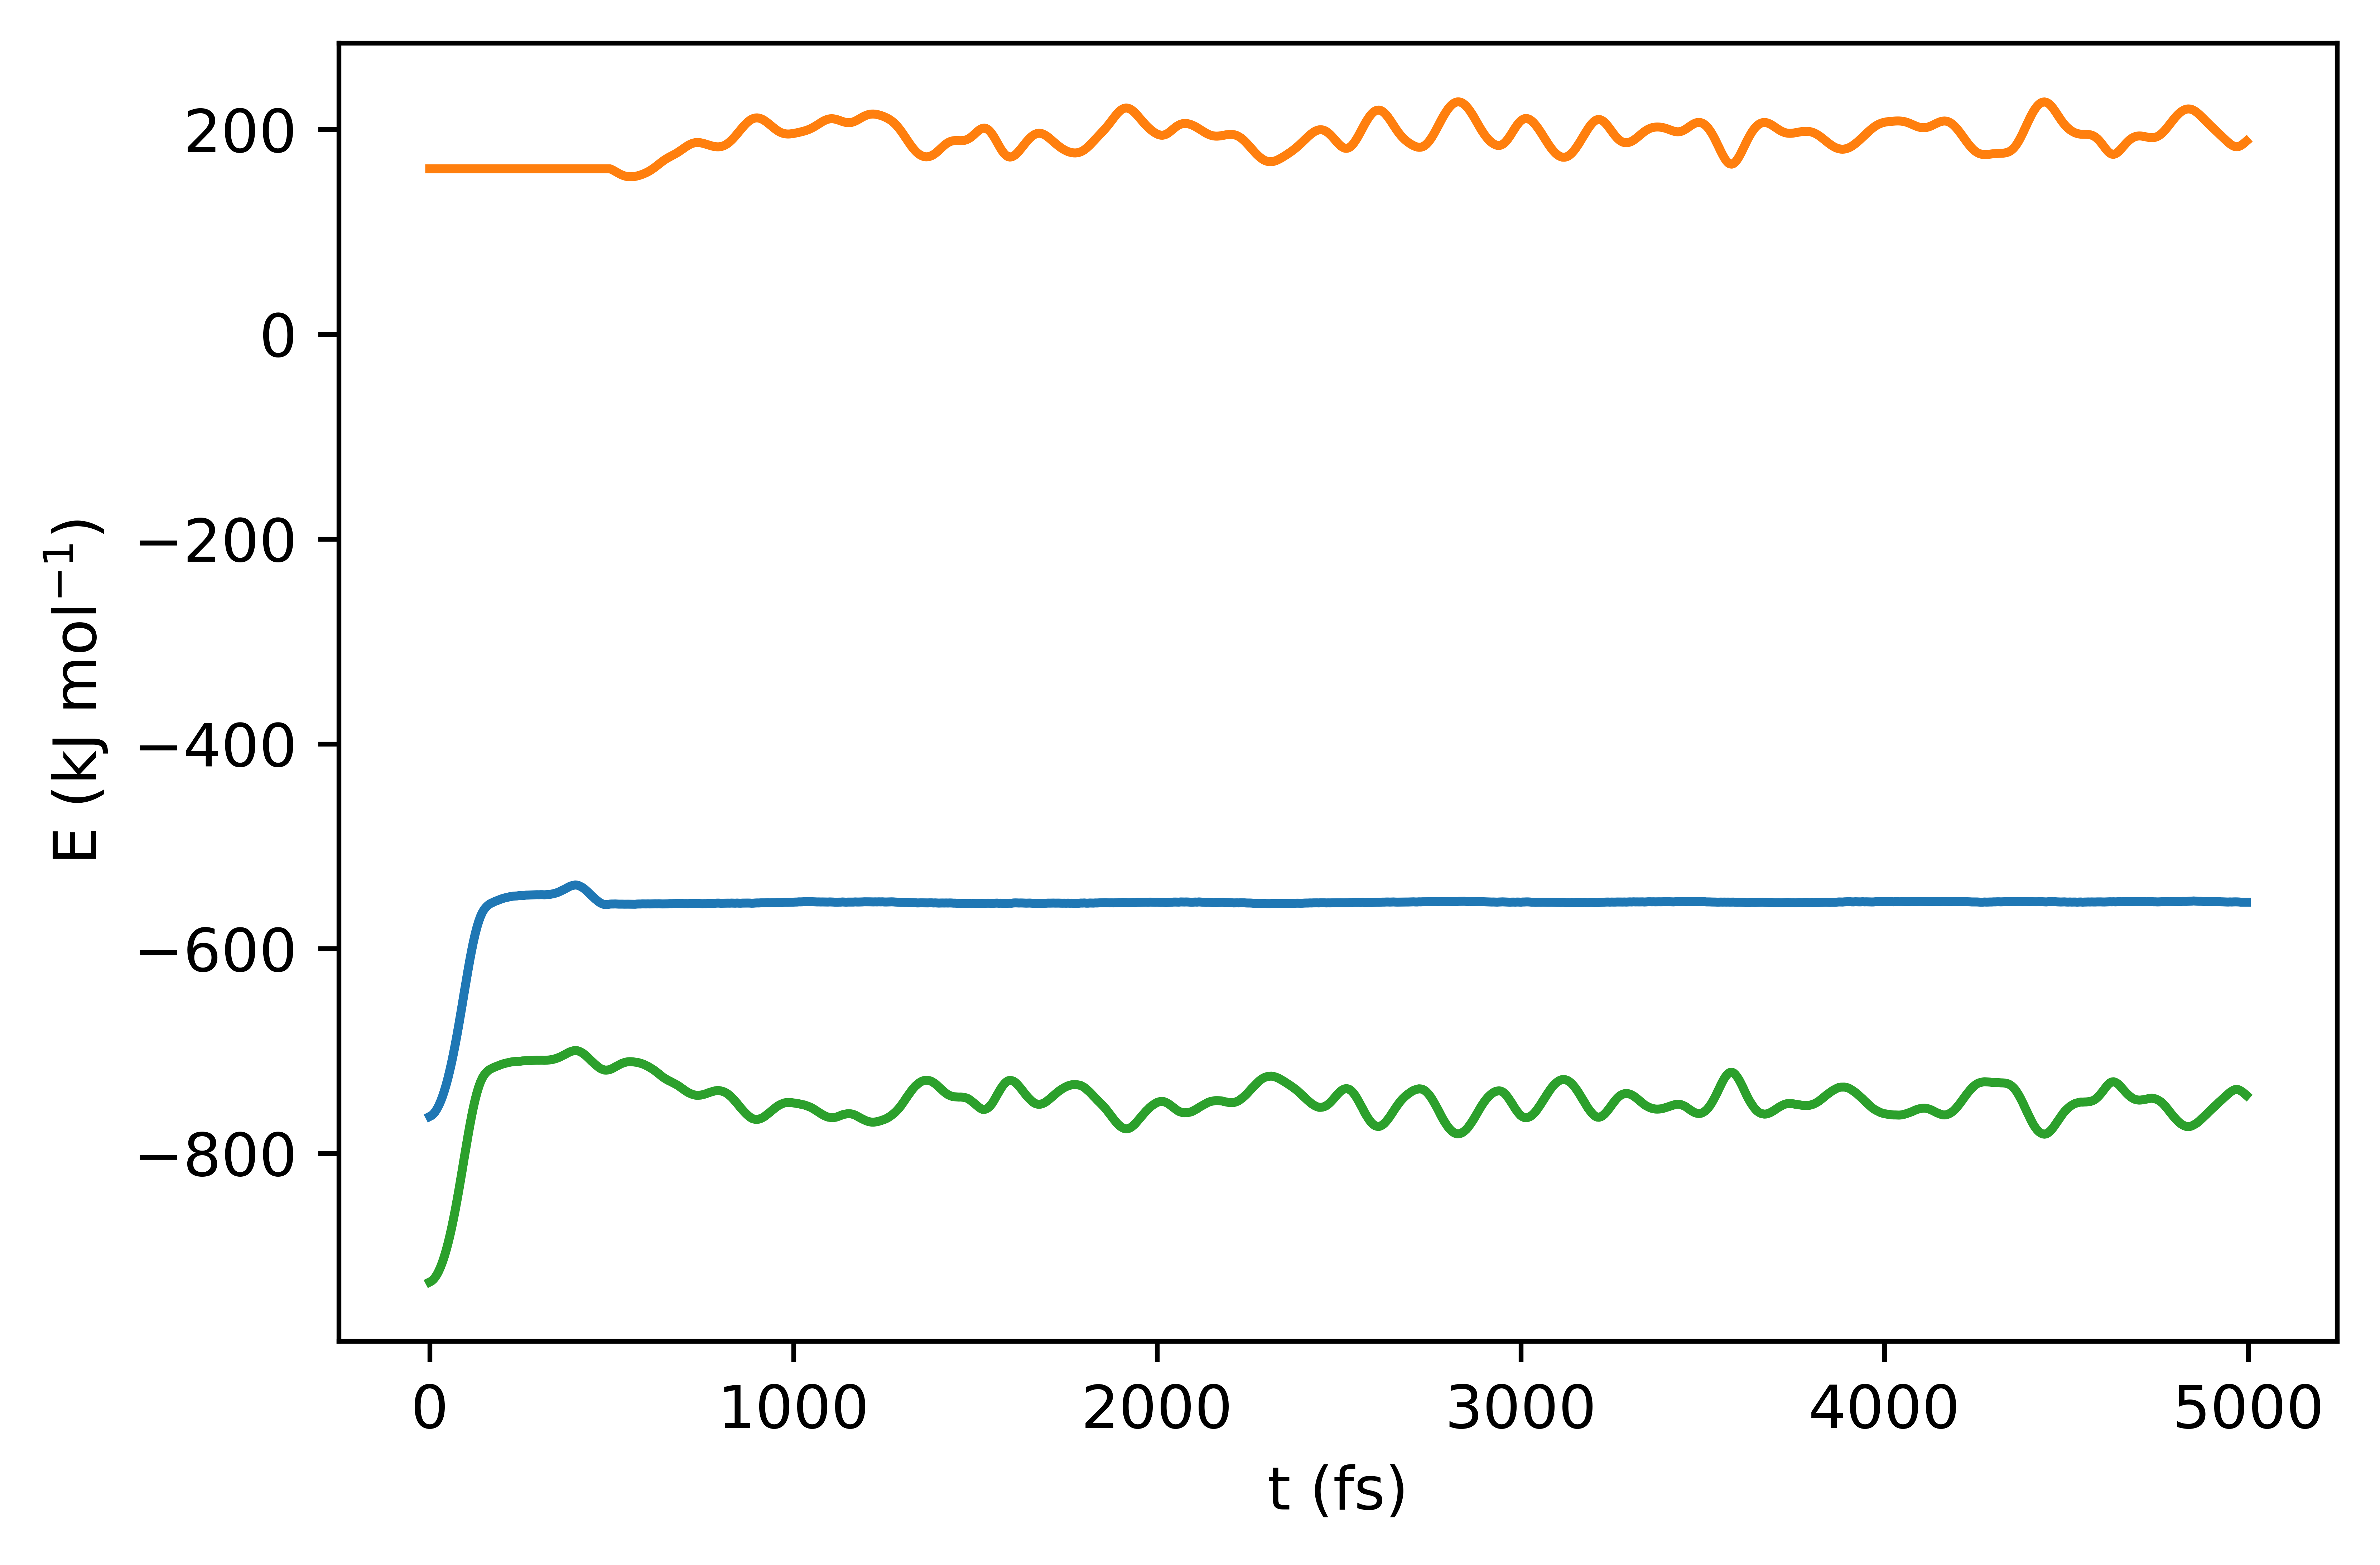

In [61]:
plt.figure(dpi=1200)
plt.rc('text', usetex=False)
plt.plot(time,total_energy)
plt.plot(time,kinetic_energy)
plt.plot(time,potential_energy)
plt.xlabel(r't (fs)')
plt.ylabel(r'E (kJ mol$^{-1}$)')

Same for the temperature

Text(0, 0.5, 'T (K)')

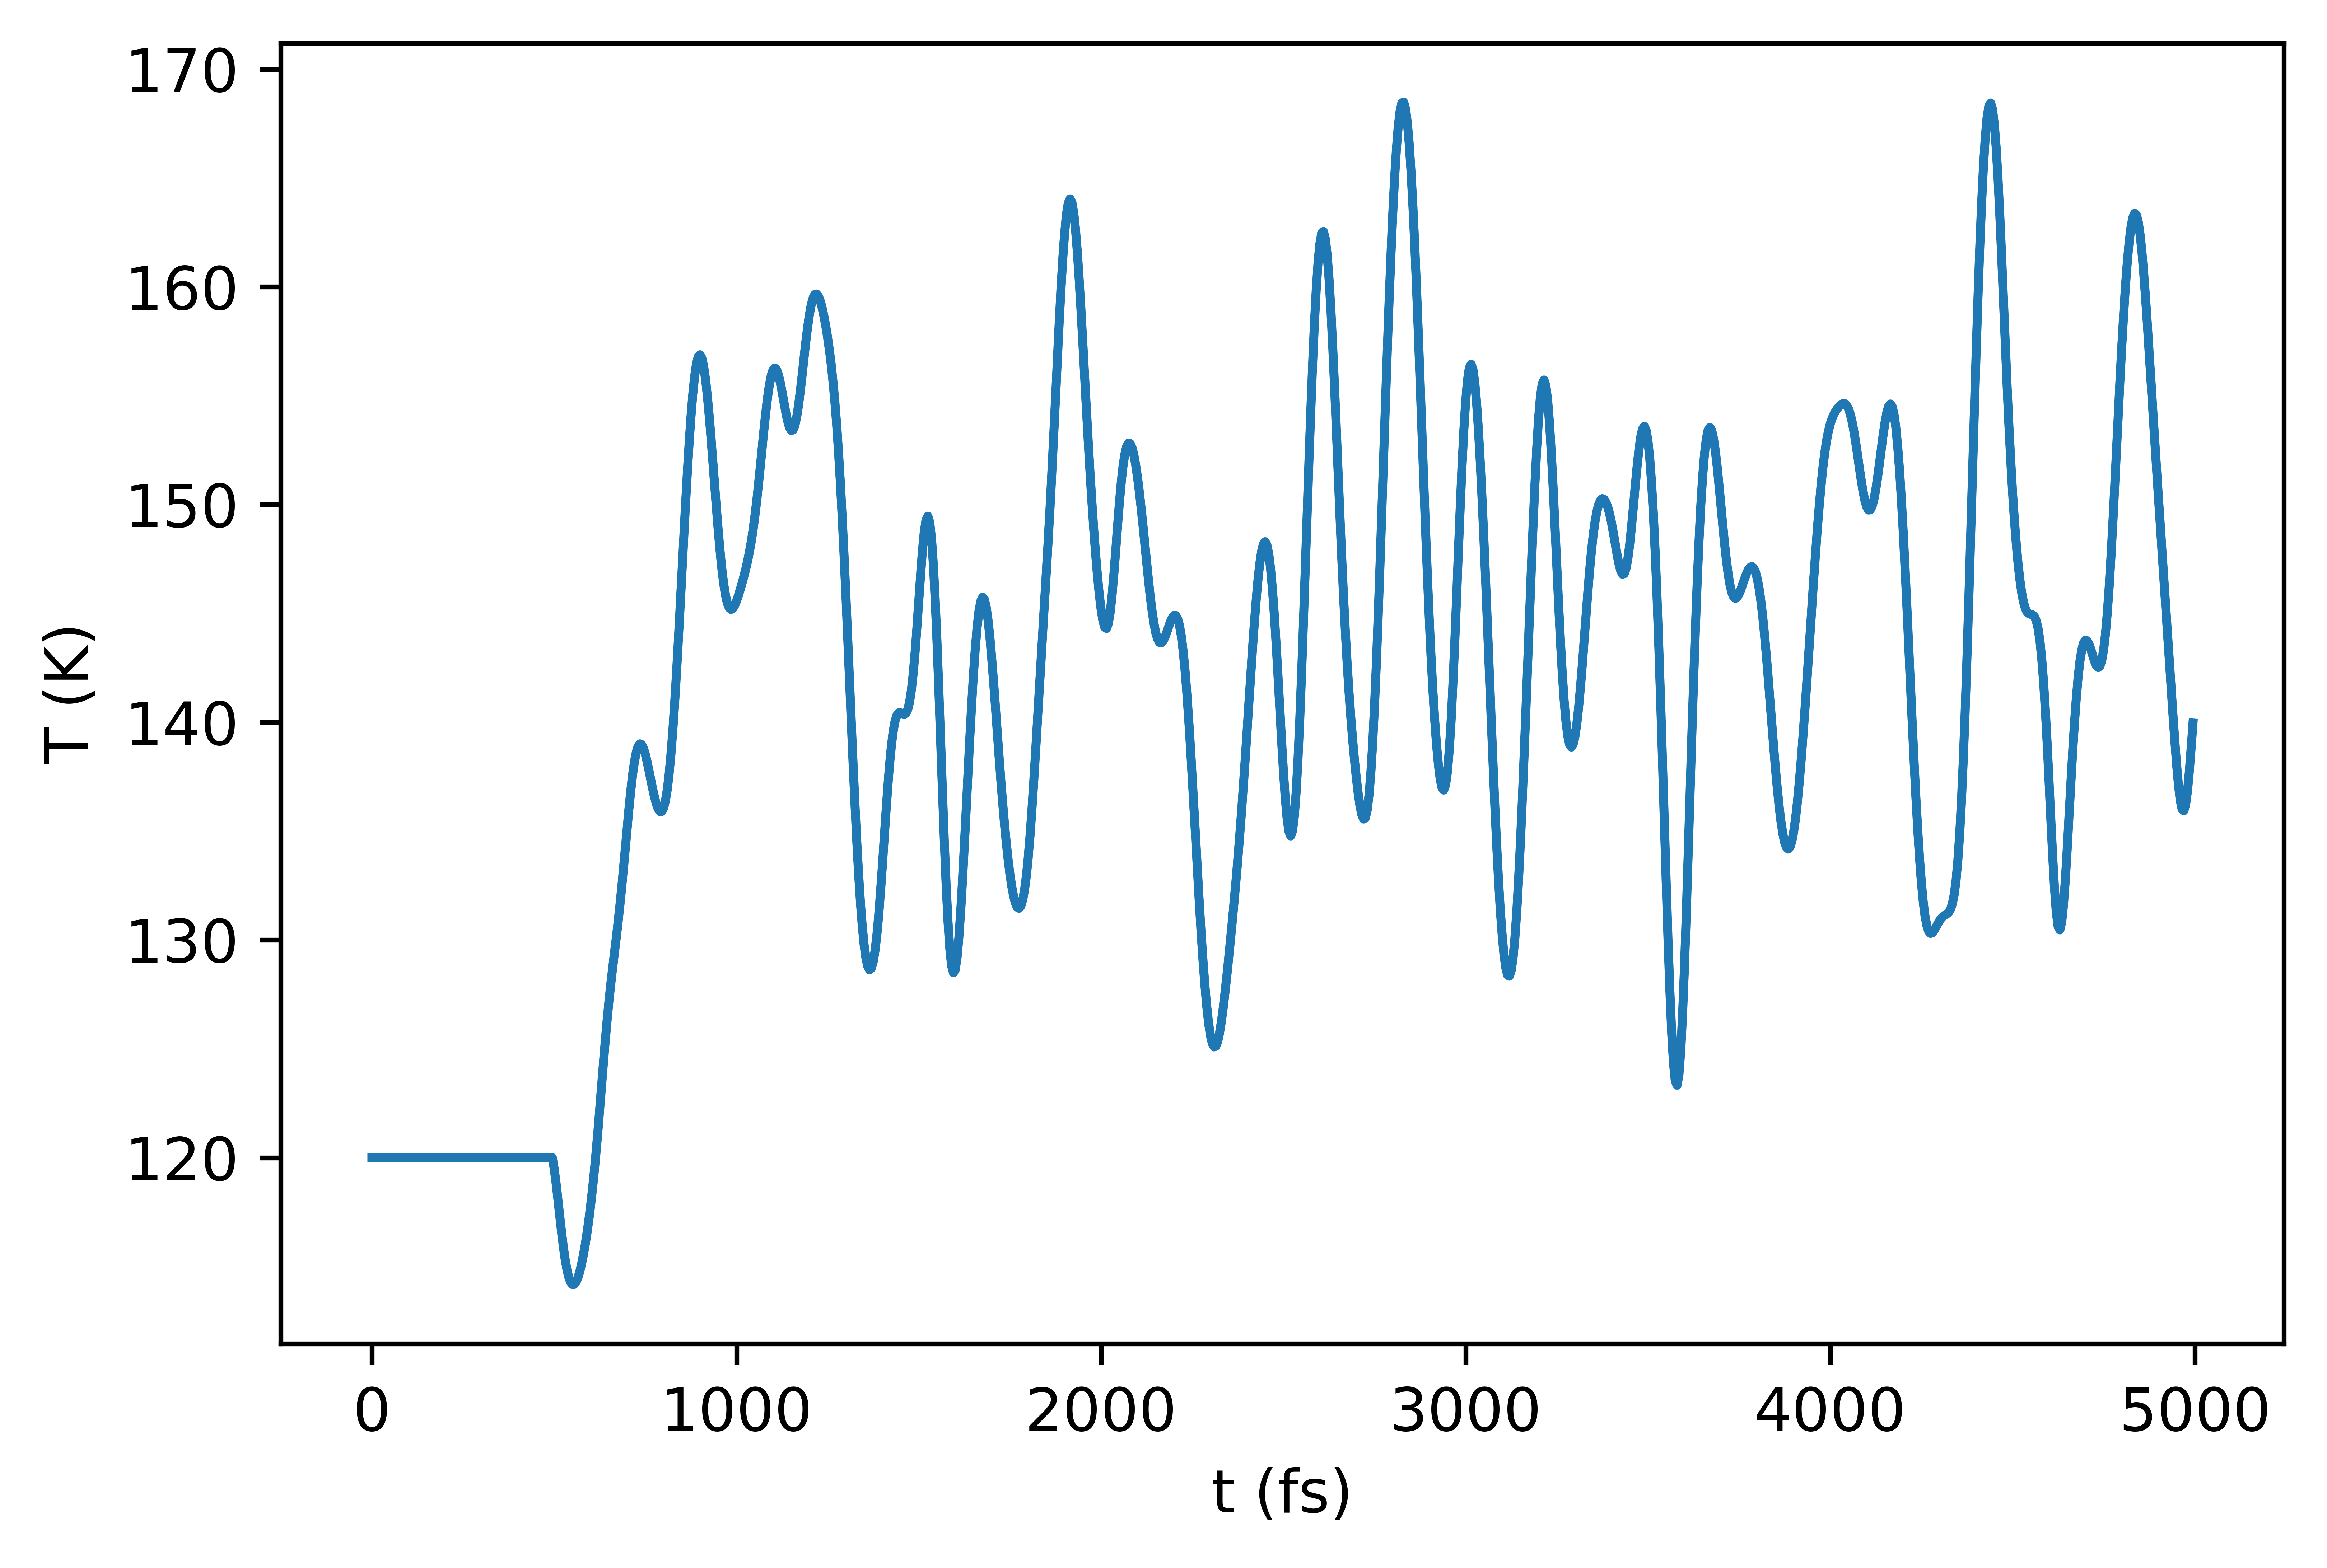

In [62]:
plt.figure(dpi=1200)
plt.rc('text', usetex=False)
plt.plot(time,temperature)
plt.xlabel(r't (fs)')
plt.ylabel(r'T (K)')

We can visualize the positions that are collected in `coords_MD`. First we need to convert from a `NumPy` array to a data structure that can be used with `nglview`. Here, the coordinates will be imported using `MDAnalysis`.

In [63]:
U1 = Generate_MD_Traj(Natoms,'Ar',Box_size,coords_MD)

In [64]:
show_simulation = Visualize_Trajectory(U1)
show_simulation

NGLWidget(max_frame=99)

We can also plot the [radial distribution functions](https://en.wikipedia.org/wiki/Radial_distribution_function) which provide important information on the structure of the system

Text(0, 0.5, 'g(r)')

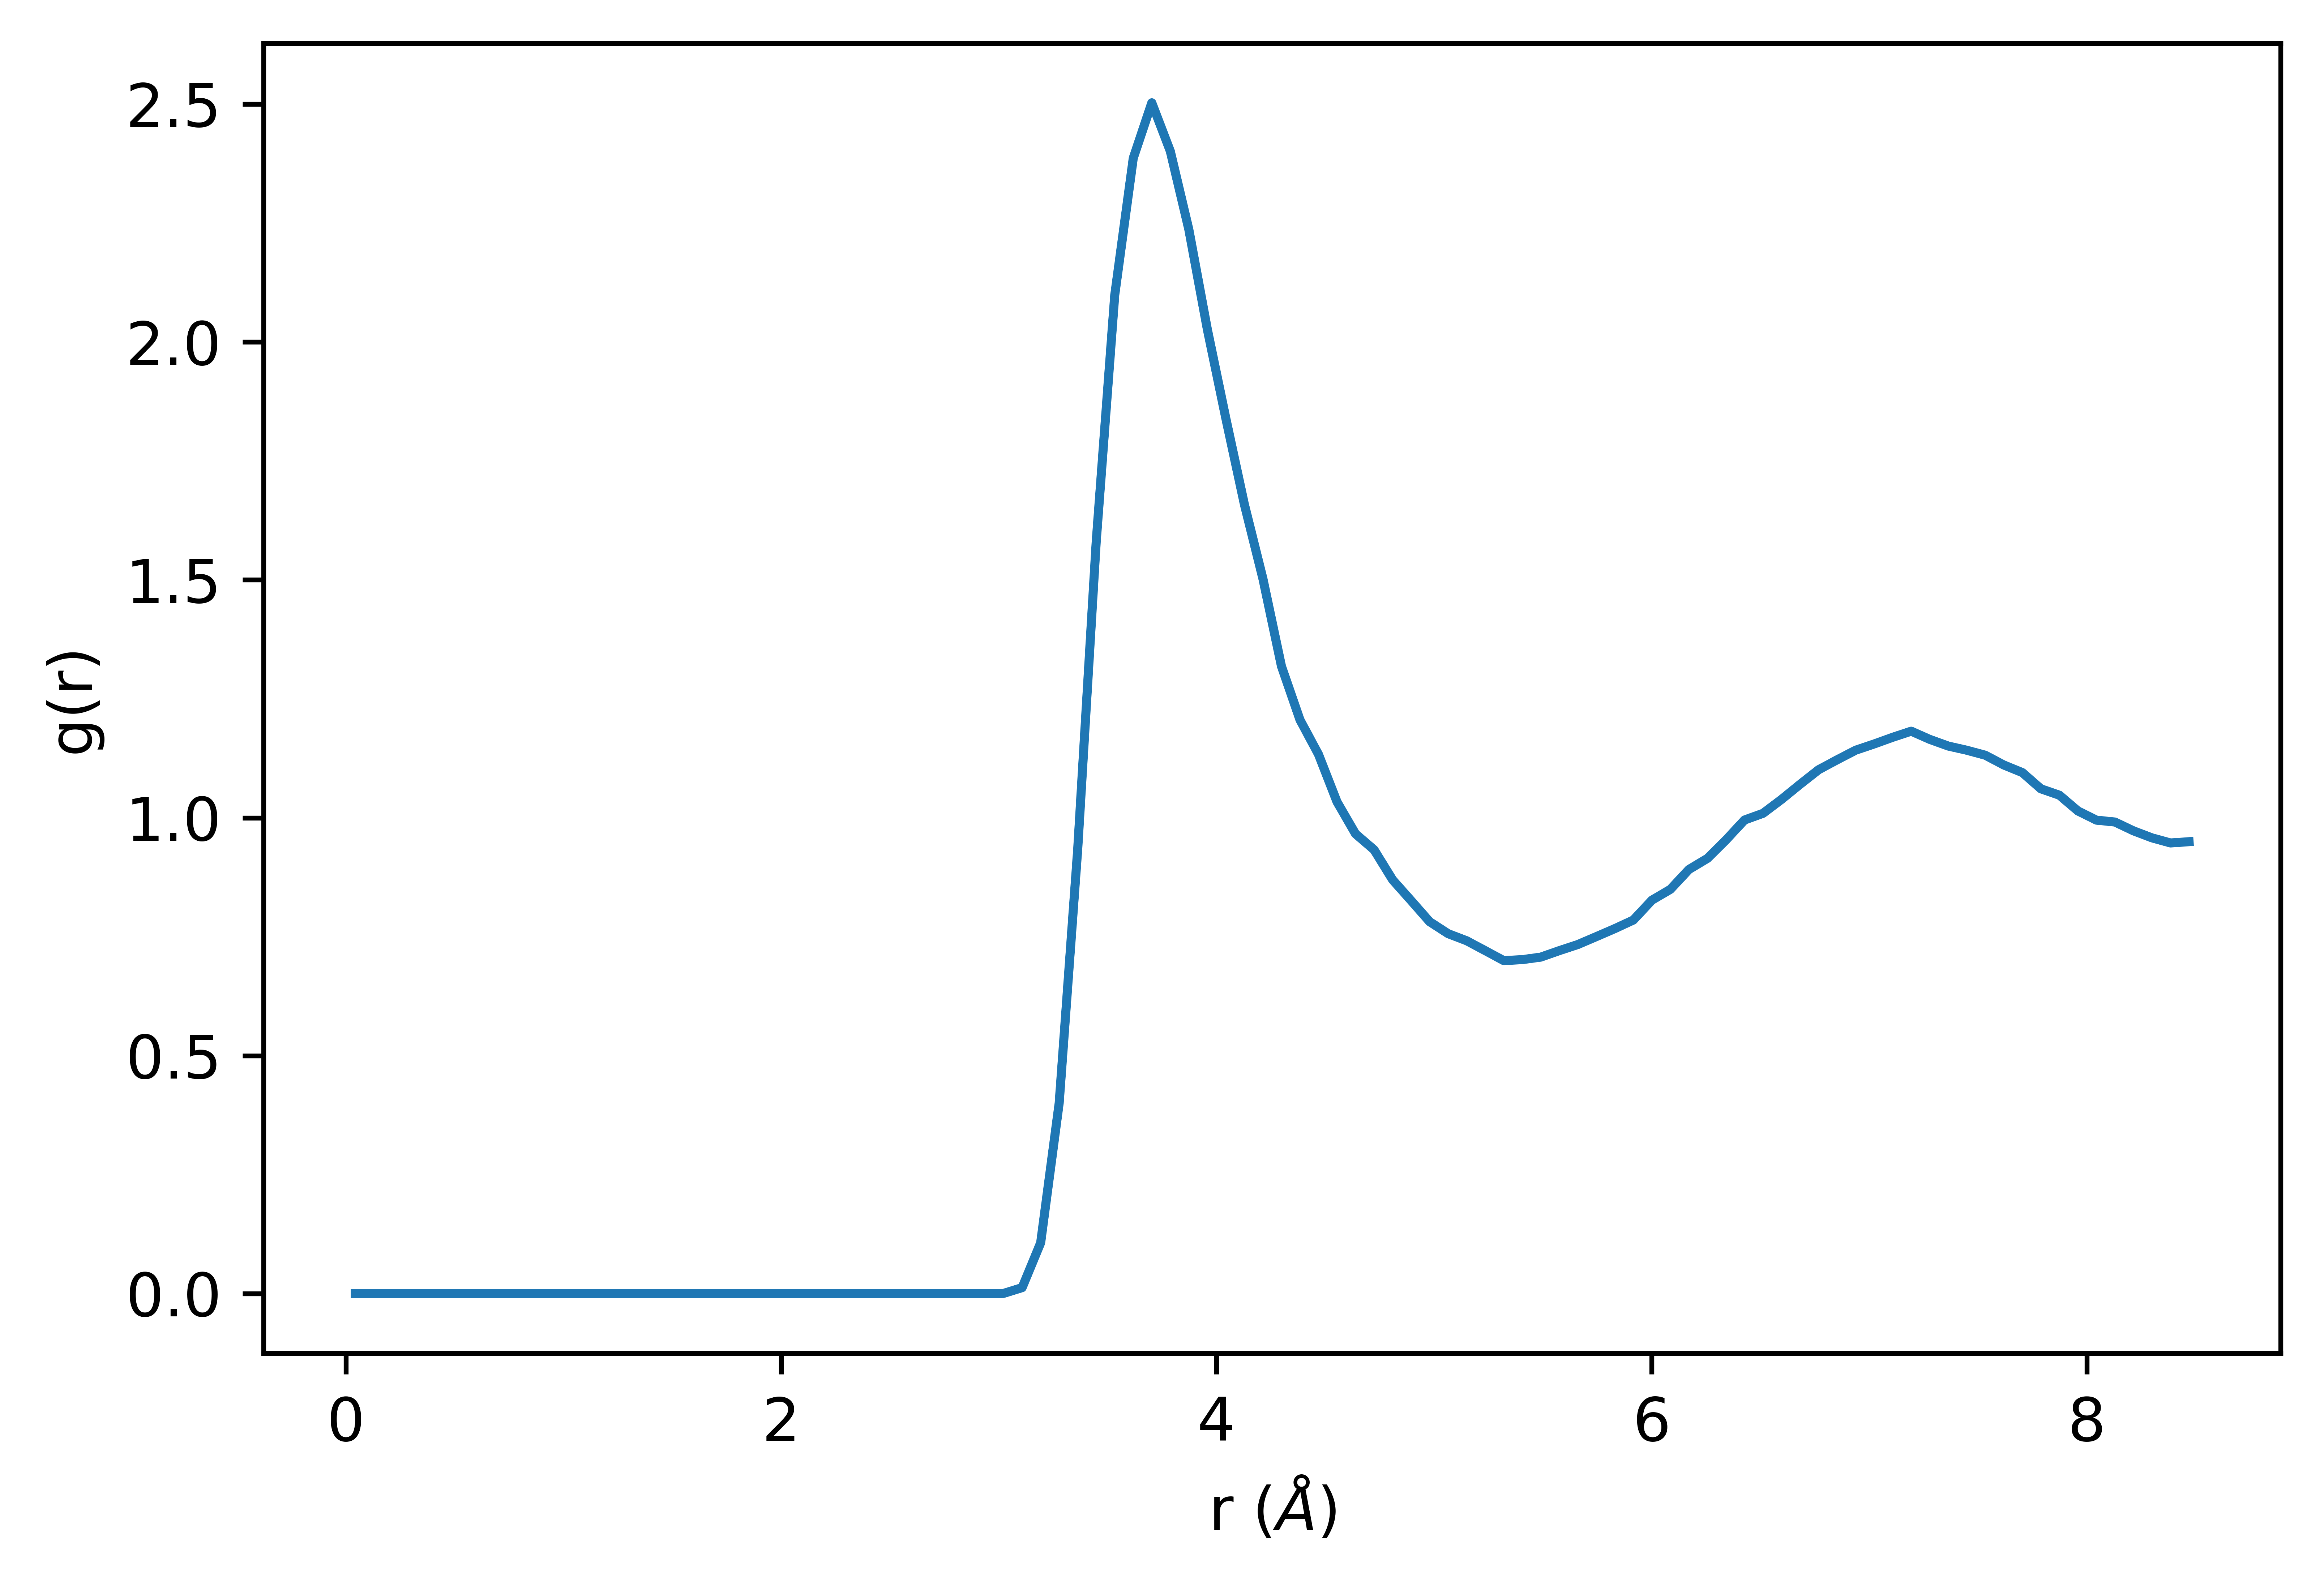

In [67]:
plt.figure(dpi=1200)
prefactor = 6.0 * Box_size**3 / (Natoms*Natoms*(Nsteps-Nequil)*4.0*Pi)
r = np.zeros([Ngrid_rdf])
rdf2 = np.zeros([Ngrid_rdf])
for i in range(Ngrid_rdf):
    rlower = i * Dr_rdf
    rupper = rlower + Dr_rdf
    r[i]=0.5*(rlower+rupper)*Length_au2Angstrom
    normalization = prefactor / (rupper**3-rlower**3)
    rdf2[i] = rdf[i] * normalization
plt.rc('text', usetex=False)
plt.plot(r,rdf2)
plt.xlabel(r'r ($\AA$)')
plt.ylabel(r'g(r)')    
    